# Introduction: nonlinear and causal timeseries analysis with Julia

_Keep in mind: theoretical background on **delay coordinates embedding** is useful to **understand** the methodological approach and to make better decisions regarding the parameters of the algorithms. On the bright side, to understand the code, delay embedding knowledge isn't necessary. In practice this means that you can learn to use this code base and return to it again after having learnt delay coordinates embedding_

Quick theme change for plotting in zoomed-in Jupyter notebooks:

In [11]:
using CairoMakie
update_theme!(resolution = (500, 300), fontsize = 16)

# ComplexityMeasures.jl

ComplexityMeasures.jl is the most complete and most and performant software for computing quantities relevant in nonlinear timeseries analysis. 

"Nonlinear" timeseries analysis is a generic term that in simply means: "extract quantities from the timeseries that are inspired by nonlinear dynamics processes and quantify _dynamic_ information about the data". Dynamic information is information about _how data change with time_. This is contrasting to statistical information (such as mean or variance).

## Probabilities from timeseries

Complexity measures are estimated from _probability distributions_. Hence, the data first need to be cast into a form of a probability distribution. ComplexityMeasures.jl offers a `ProbabilitiesEstimator` interface. Various estimators are offered and their role is to decide how discrete probabilities are extracted from data when given to the `probabilities` function.

### `ValueHistogram`

A way to cast data into probabilities that most will be familiar with is to get their histogram, which is what the estimator `ValueHistogram` does.

In [12]:
using ComplexityMeasures
probest = ValueHistogram(21); # makes histogram with `21` bins per dimension

To demonstrate, let's apply this estimator to an eample timeseries:

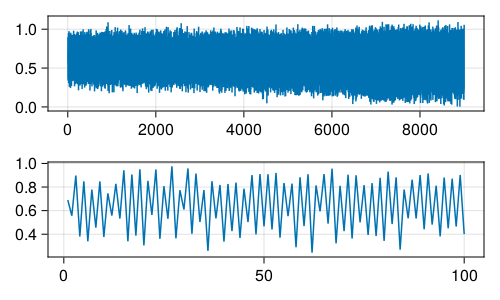

In [13]:
using Downloads, DelimitedFiles
file = Downloads.download("https://raw.githubusercontent.com/JuliaDynamics/NonlinearDynamicsTextbook/master/exercise_data/7.csv")
x = vec(readdlm(file))
fig, = lines(x)
lines(fig[2,1], x[1:100])
fig

To extract probabilities, call the `probabilities` function and give it the probabilities estimator and the input data `x`:

In [14]:
probs = probabilities(probest, x)

21-element Probabilities{Float64, 1}:
 0.002221235006663705
 0.010328742780986229
 0.02665482007996446
 0.035650821856952467
 0.03698356286095069
 0.04531319413593958
 0.04320302087960906
 0.049089293647267884
 0.055308751665926255
 0.0504220346512661
 ⋮
 0.057418924922256774
 0.061417147934251445
 0.07385606397156819
 0.09062638827187916
 0.10561972456685917
 0.09195912927587739
 0.05053309640159929
 0.012549977787649933
 0.0016659262549977788

21 probability values were returned, each for each constructed bin. Let's visaulize

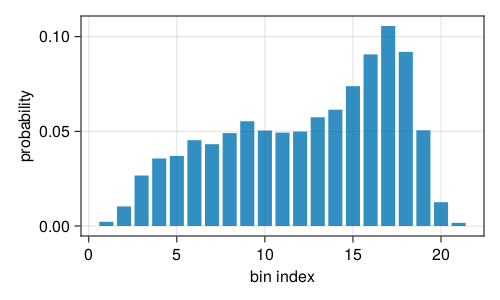

In [15]:
fig, ax = barplot(probs)
ax.xlabel = "bin index"
ax.ylabel = "probability"
fig

As you see, `probabilities` returns only the probabilities themselves. If you want the _outcomes_ corresponding to the probabilities, you need to call `probabilities_and_outcomes`. "Outcomes" here is a general word, and what it represents depends on the probabilities estimator. For `ValueHistogram` the outcomes are the left edges of each bin.

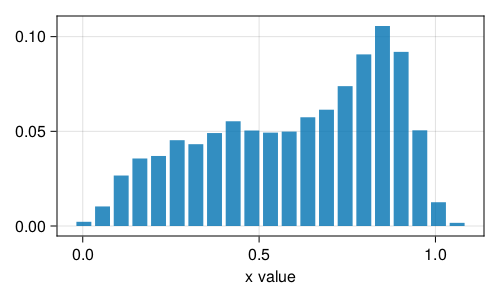

In [16]:
probs, outs = probabilities_and_outcomes(probest, x)
outs = reinterpret(Float64, outs) # outs are always vectors of vectors, even for 1D
fig, ax = barplot(outs, probs)
ax.xlabel = "x value"
fig

### `SymbolicPermutation` 

An alternative way to cast data into probabilities is using _symbolic permutations_, also known as _ordinal patterns_. This is done by the estimator `SymbolicPermutation`, which takes in an order `m` as an argument.

In [17]:
probest = SymbolicPermutation(m = 3);

We can extract probabilities and plot them just like before, but now the plot won't be the "traditional histogram" we are vamiliar with, but a probability mass function (discrete probability density)

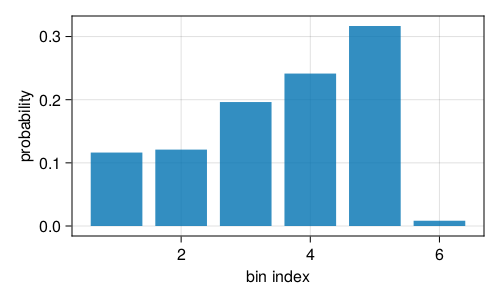

In [18]:
probs = probabilities(probest, x)
fig, ax = barplot(probs)
ax.xlabel = "bin index"
ax.ylabel = "probability"
fig

The outcomes corresponding to the above probabilities are the _ordinal patterns_ of `m`-consecutive points of the timeseries `x`.

Here is some fancy visualizing code that makes things clear:

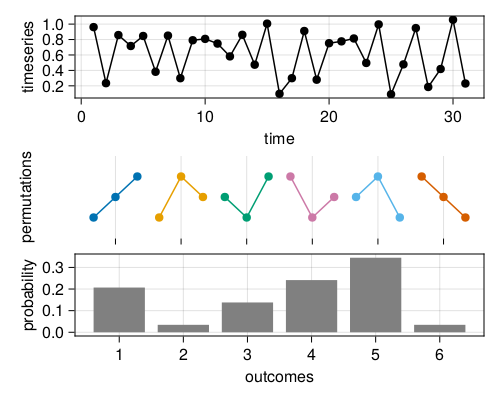

In [19]:
xsmall = x[end-30:end]
fig = Figure(resolution = (500,400))
scatterlines(fig[1,1], xsmall; color = "black",
    axis = (ylabel = "timeseries", xlabel = "time"), 
)
# Obtain, and then plot, the ordinal patterns (i.e., the outcomes!)
probest = SymbolicPermutation(m = 3)
probs, outs = probabilities_and_outcomes(probest, xsmall)
ax_outs = Axis(fig[2,1]; ylabel = "permutations", xticks = (2:3:19, string.(1:6)))
ylims!(ax_outs, 0, 4)
for (i, o) in enumerate(outs)
    s = Vector(sortperm(o))
    scatterlines!(ax_outs, 3*(i-1) .+ (1:3), s)
end
hidespines!(ax_outs)
hideydecorations!(ax_outs; label = false)
ax_outs.ylabelpadding = 40
ax_outs.xticklabelsvisible = false
# Plot also the probabilities for each permutation
barplot(fig[3,1], probs; color = "gray", 
    axis = (xticks = 1:6, xlabel = "outcomes", ylabel = "probability")
)
rowgap!(fig.layout, 10)

fig

## Obtaining complexity measures

### Entropies

While these probabilities are fine, what we really care about is computing the entropy of these probabilities. To be precise, we will compute the _Shannon entropy_. ComplexityMeasures.jl offers many other entropies, but in this simple tutorial we keep things basic. Shannon entropy is defined by

$$
H(p) = - \sum_i p[i] \log(p[i])
$$

To compute an entropy directly from a probability mass function you simply call the `entropy` function, which by default will compute the Shannon entropy:

In [20]:
H = entropy(probs)

2.224169256934338

It is almost aways preferred to compute the _normalized_ entropy, which is the above value divided by the maximum possible value for the entropy. The maximum possible value cannot be dediced directly from a probabilities container, because typically events with 0 probability are ignored and not even included in the computed probabilities. But no problem, we can call `entropy_normalized` with the probabilities estimator and the input data, which computes the probabilities and maximum entropy automatically and returns the normalized result.

In [21]:
h = entropy_normalized(probest, x)

0.8776160090372542

What we calculated above is the (normalized) **permutation entropy**. This quantifier of timeseries complexity is one of the most frequently used quantities in the context of timeseries analysis. The smaller `h` is, the more regular and more deterministic the timeseries is. Contrarily, the closer to 1 `h` is, the more noisy and random the time series is. Additionally, computing `h` is ultra fast, robust versus noise, and invariant under monotonic transformations of input timeseries `x`.

Of course, _any_ valid probabilities estimator may be used instead of `SymbolicPermutation` in the call of `entropy_normalized`, and this again will compute the corresponding entropy of the probabilities associated with the given probabilities estimator. For example

In [22]:
h_histo = entropy_normalized(ValueHistogram(21), x)

0.9359699420721946

### Other complexity measures

We have seen 2 out of the 5 core components of ComplexityMeasures.jl: `ProbabilitiesEstimator` and the `probabilities` function, and the default case of the `entropy` function applied either to a probability mass function or a probabilities estimator. The next 2 core components of ComplexityMeasures.jl are alternative definitions of discrete entropies, and differential entropies. We won't discuss these in this introductory level.

The 5th core component is the `complexity` function, which is called when calculating other complexity measures that are not entropies in the strict mathematical definition. `complexity` works practically identically to `entropy`. First, one chooses a `ComplexityEstimator`, and calls `complexity` with this estimator and input data.

In [23]:
complest = SampleEntropy(; r = 0.25)
c = complexity(complest, x)

0.35383430034769503

and similar with `entropy`, there is also a `complexity_normalized` function, which in the majority of cases is the preferred function to use

In [24]:
c = complexity_normalized(complest, x)

0.020199312013699833

The quantity we computed above is the (normalized) **sample entropy**. It has been developed to be particularly useful in the analysis of physiological timeseries, which are characterized by very short lengths and low signal-to-noise ratio.

_Warning: even though it is named "entropy", sample entropy is not an entropy in the strict mathematical sense!_

## Application: detecting changes of dynamical behavior

There are many different application scenarios one can use these complexity measures for. Examples include classification of timeseries, surrogate testing (second block), and more. Here we highlight another useful application, detecting changes in the dynamics.


The timeseries we have been using so far is generated by a non-stationary nonlinear dynamical system (the logistic map), also with added observational Gaussian noise. While the generating dynamics are mostly chaotic, a transition to complete periodic dynamics occurs during the system evolution. Let's try to see if we can detect when this happens numerically by using the aforementioned complexity measures. Let's also compare with standard statistical quantifiers.

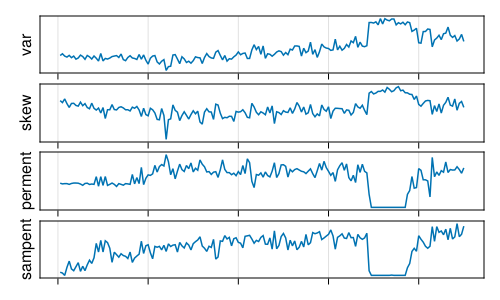

In [25]:
using StatsBase: var, skewness
# Collect measures to apply over a sliding window
measures = [
    var,
    skewness,
    x -> entropy_normalized(SymbolicPermutation(m = 3), x), # permutation entropy
    x -> complexity_normalized(SampleEntropy(r = 0.25), x), # sample entropy
]
labels = ["var", "skew", "perment", "sampent"]
# compute all measures over a sliding window of `x`
window = 50
function apply_over_sliding_window(f, x, w)
    map(1:w:(length(x)-w)) do i
        z = view(x, i:(i+w))
        f(z)
    end
end
measures_mapped = map(f -> apply_over_sliding_window(f, x, window), measures)
# Plot results
fig = Figure()
for (i, m) in enumerate(measures_mapped)
    # applied = apply_over_sliding_window(f, x, window)
    ax, = lines(fig[i, 1], window:window:length(x), m, axis = (ylabel = labels[i],))
    hideydecorations!(ax; label = false)
    hidexdecorations!(ax; grid = false, ticks = false)
end
rowgap!(fig.layout, 5)
fig

Alright, from looking at the complexity measure plots, where the system transitions to regular dynamics become spectacularly clear and practically completely unafected by noise.

While there seems to be a slight plateau in the statistical measures, it isn't as clear. Besides, there is no dynamic information in the plateau either: increase of standard deviation in the timeseries means nothing without specific assumptions on the system that generated the timeseries (i.e., you'd need some external reason to associate higher variance with higher regularity in the dynamics).

---

# TimeseriesSurrogates.jl

This package is the most complete and most performant software for performing timeseries surrogates hypothesis testing.

### What is a surrogate timeseries?
A surrogate of a timeseries `x` is another timeseries `s` of equal length to `x`. This surrogate `s` is generated from `x` so that it roughly preserves
one or many pre-defined properties of `x`, but is otherwise randomized.

The upper panel in the figure below shows an example of a timeseries and one
surrogate realization that preserves its both power spectrum and its amplitude distribution (histogram). Because of this preservation, the time series look similar.

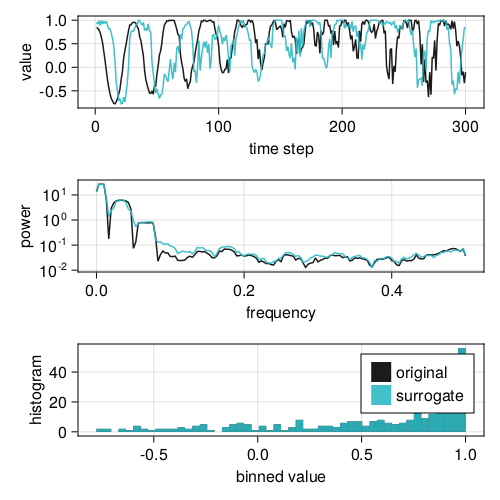

In [26]:
using TimeseriesSurrogates
x = LinRange(0, 20π, 300) .+ 0.05 .* rand(300)
ts = sin.(x./rand(20:30, 300) + cos.(x))
s = surrogate(ts, IAAFT())
surroplot(ts, s)


### Performing surrogate hypothesis tests

A surrogate test is a statistical test of whether a given timeseries satisfies or not a given hypothesis regarding its properties or origin.

For example, the first surrogate methods were created to test the hypothesis,
whether a given timeseries `x` that appears noisy may be the result of a linear
stochastic process or not. If not, it may be a nonlinear process contaminated with observational noise.

To perform such a surrogate test, you need to:

1. Decide what hypothesis to test against
2. Pick a surrogate generating `method` that satisfies the chosen hypothesis
3. Pick a suitable discriminatory statistic `q` with `q(x) ∈ Real`. It must be a statistic that would obtain sufficiently different values for timeseries satisfying, or not, the chosen hypothesis.
4. Compute `q(s)` for thousands of surrogate realizations `s = surrogate(x, method)`
5. Compare `q(x)` with the distribution of `q(s)`. If `q(x)` is significantly outside the e.g., 5-95 confidence interval of the distribution, the hypothesis is rejected.

## Example using TimeseriesSurrogates.jl

For this example we will stick with one of the first usage cases of the methodology: testing whether a timeseries can be interpreted as a linear stochastic process or not.

TimeseriesSurrogates.jl provides 21 different methods for generating surrogates. Each method is fully documented, and in its documentation string explains for what kind of hypothesis it is suitable for. One would have to find the appropriate ones for this hypothesis. For our application, the most basic suitable method is `RandomFourier()` that generates timeseries with same power spectrum as the original one.

In [27]:
using Random: Xoshiro  # for reproducibility
rng = Xoshiro(1234567) # random number generator

using TimeseriesSurrogates
method = RandomFourier()

RandomFourier(true)

Let's see how a timeseries that actually _does follow_ a linear stochastic process looks like, as well as how its surrogate looks like!

In [28]:
n = 400 # timeseries length
x = TimeseriesSurrogates.AR1(; n_steps = n, k = 0.25, rng); # example timeseries

To generate a surrogate you simply call the `surrogate` function

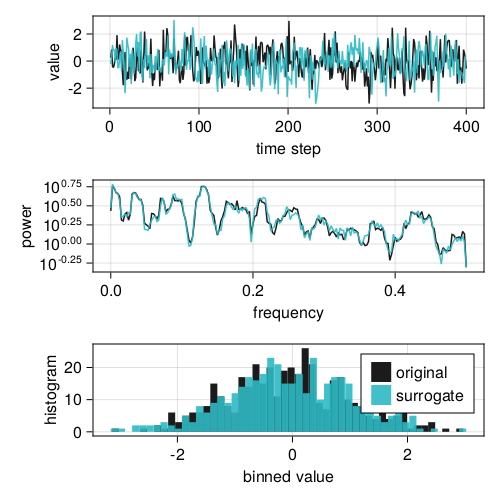

In [29]:
s = surrogate(x, method)
using CairoMakie
surroplot(x, s) # comparison plot of two timeseries

As you can see in the plot, the method `RandomFourier()` approximately preserves the power spectrum of the original timeseries, but not its amplitude distribution.

To perform a surrogate test now we need to choose a discriminatory statistic; in our case this could be something that gives information about temporal correlations such as the self-mutual-information, or something that gives information about structure in state space that a nonlinear system would have, such as the fractal dimension. Since we have already gone through ComplexityMeasures.jl, a simple discriminatory statistic that takes temporal information into accout is the permutation entropy!

Let's perform then the surrogate test; Since we want to apply a process to many surrogate realizations, it is now best to use the `surrogenerator` interface over `surrogate`. We initialize a "surrogate generator"

In [30]:
sgen = surrogenerator(x, method)

Surrogate generator for input timeseries 400-element Vector{Float64} with method:
RandomFourier(true)

and when called as a function with 0 arguments, `sgen` generates a surrogate timeseries of `x`

In [31]:
s = sgen()

400-element Vector{Float64}:
  0.07964083542785035
  0.1346635061499084
  1.465643137684672
 -1.3462666841469588
  0.36045351271450415
 -0.4339537741184694
  1.1587080442248037
 -0.703324918933832
 -0.6379614559037492
 -0.6087356273247073
  ⋮
 -0.8719346534289415
  0.9554032956298607
  0.7905596704436558
 -1.7327835828376132
 -0.26763511105579446
  0.8890660543719549
  0.13367979157758458
  0.06825423571729729
  0.08236403622973974

Now we're ready to make a histogram of the discriminatory statistic for `x` and many other surrogates

In [32]:
using ComplexityMeasures

m = 3 # order of permutation
N = 10_000 # how many surrogates to use
q = x -> entropy_normalized(SymbolicPermutation(; m), x)
qx = q(x)
qs = map(q, (sgen() for _ in 1:N))

10000-element Vector{Float64}:
 0.9981793524787168
 0.9982748682963611
 0.9890478444887522
 0.9919529711369557
 0.9988641822127731
 0.9929790464553786
 0.9925457189234768
 0.9960960601370544
 0.994606308775477
 0.9963497665771159
 ⋮
 0.9985841977299481
 0.9973524883625446
 0.9958796306810908
 0.9977678363239336
 0.9979331321479709
 0.993814341743442
 0.9960840604372447
 0.9951023016886311
 0.9950152126500674

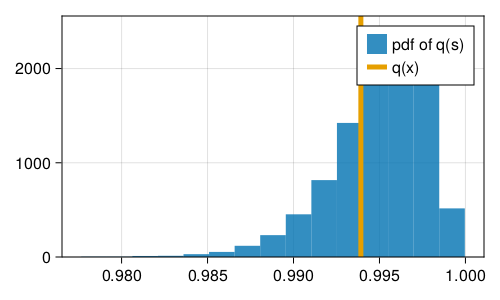

In [33]:
fig, ax = CairoMakie.hist(qs; label = "pdf of q(s)")
vlines!(ax, qx; color = Cycled(2), linewidth = 5, label = "q(x)")
axislegend(ax)
ylims!(ax, 0, nothing)
fig

In [34]:
using Statistics
q01, q99 = quantile(qs, [0.01, 0.99])
q01 ≤ qx ≤ q99 # if false, hypothesis can be rejected!

true

Alright, so far this application was rather simple. But let's perform exactly the same thing but now for a timeseries that is indeed generated by a deterministic nonlinear process contaminated with noise. 

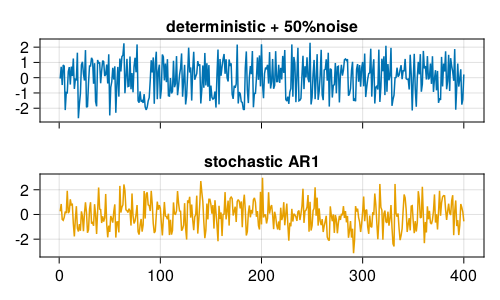

In [35]:
using DynamicalSystemsBase
ds = Systems.logistic(r = 4.0)
y = trajectory(ds, n-1)
# Add 50% observational noise
y = standardize(y) .+ 0.5randn(rng, n)
fig, ax1 = lines(y)
ax2, = lines(fig[2,1], x, color = Cycled(2))
ax1.title = "deterministic + 50%noise"
ax1.xticklabelsvisible = false
ax2.title = "stochastic AR1"
fig

Without labels, it isn't so easy to distinguish stochastic from nonlinear noisy, is it? Let's repeat the same surrogate test.

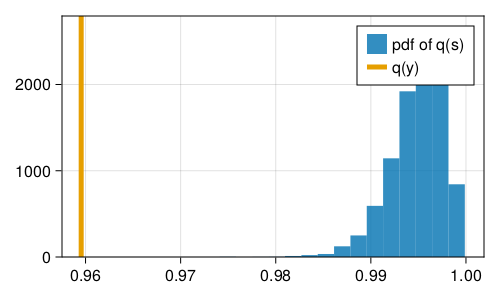

In [36]:
# make distribution of surrogate statistics
sgen = surrogenerator(x, RandomFourier(), rng)
qy = q(y)
qs = map(q, (sgen() for _ in 1:N))
# plot
fig, ax = CairoMakie.hist(qs; label = "pdf of q(s)")
vlines!(ax, qy; color = Cycled(2), linewidth = 5, label = "q(y)")
axislegend(ax)
ylims!(ax, 0, nothing)
fig

In [37]:
q01, q99 = quantile(qs, [0.01, 0.99])
q01 ≤ qy ≤ q99 # if `false`, hypothesis can be rejected!

false

And keep in mind this is even though we have very short timeseries of just 400 points or so, but also that there is a 50% noise added to the first! Timeseries surrogate hypothesis testing is an integral part of any timeseries analysis workflow, whether it is causal, nonlinear, or statistical.

# Exercises - nonlinear timeseries analysis

## Detecting seizures in EEG timeseries

Use the following code to download an EEG timeseries of a person undergoing seizures. Perform a similar analysis to the one we performed using permutation entropy to identify when the seizure takes place.

_hint: in real world timeseries, when calculating the probabilities of the ordinal patterns, one must also tune the "delay time" `τ`, i.e., how far into the past to go when making the `m`-order ordinal permutations. Because the timeseries here has been subsampled, you can stay with the default option of `τ=1`_.

In [38]:
using Downloads, DelimitedFiles
data_number = 18 # 18 r 19
file = Downloads.download("https://raw.githubusercontent.com/JuliaDynamics/NonlinearDynamicsTextbook/master/exercise_data/$(data_number).csv")
eeg = vec(DelimitedFiles.readdlm(file));

## Surrogates of atmospheric reflectance timeseries

Use the following code snippet to download two timeseries from an exercise dataset:

In [39]:
using Downloads, DelimitedFiles
file = Downloads.download("https://raw.githubusercontent.com/JuliaDynamics/NonlinearDynamicsTextbook/master/exercise_data/11.csv")
M = readdlm(file)
x, y = M[:, 1], M[:, 2];

utilizing TimeseriesSurrogates.jl show that either of `x, y` **cannot** be distinguished from a linear stochastic process with a superimposed long term trend. You may use `method = TFTS(0.1)` as the surrogate method, which is suitable for this hypothesis.

_in this exercise you are essentially reproducing the research of section 3.2 of [Datseris & Stevens (2021), Earth's Albedo and Its Symmetry](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021AV000440)_

## Categorization strength for ECG Heartbeat timeseries

Contrived example where compare "categorization strength": given some timeseires with known category (here normal or abnormal heart beating), what measures best distinguish all timeseries into two categories? 

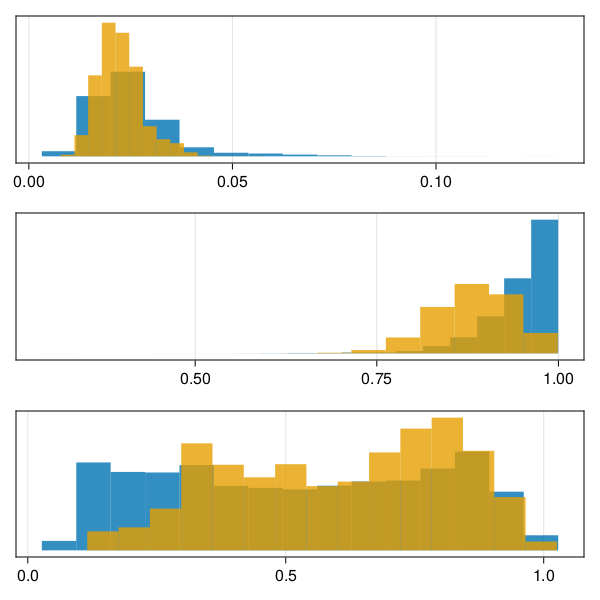

In [61]:
using DelimitedFiles
using StatsBase: var, skewness

normal = readdlm(joinpath(@__DIR__, "data", "ptbdb_normal.csv"), ',')
abnormal = readdlm(joinpath(@__DIR__, "data", "ptbdb_abnormal.csv"), ',')

using ComplexityMeasures

measures = [
    var,
    x -> entropy_normalized(SymbolicPermutation(m = 3), x),
    x -> entropy_normalized(WaveletOverlap(), x),
]

using CairoMakie
fig = Figure(resolution = (600,600))

for (i, pe) in enumerate(measures)
    ax = Axis(fig[i,1])




abnormal_pe = Float64[]
normal_pe = Float64[]

for row in eachrow(normal)
    # last entry is class (1 or 0), not part of time series
    ts = row[1:end-1]
    # delete padded zeros
    push!(normal_pe, pe(ts[ts .!= 0]))
end

for row in eachrow(abnormal)
    ts = row[1:end-1]
    push!(abnormal_pe, pe(ts[ts .!= 0]))
end

hist!(ax, abnormal_pe, normalization=:pdf, label="abnormal")
hist!(ax, normal_pe, normalization=:pdf, label="normal")
hideydecorations!(ax)
# axislegend(ax; position = :ct)
end

fig

A sensible way to quantify the "success" or "strength" a given measure has in categorizing the data into normal or abnormal is to quantify some kind of "distance" between these two histograms. The larger these two histograms are apart, the greater the separation! (Alternatively, the less the overlap between the histograms)

Such a distance in distribution space is a well defined concept and is called the Kullback–Leibler divergence from $q$ to $p$
$$
D_{KL}(p|q) = \sum_k p_k \log\frac{p_k}{q_k} 
$$
where here $k$ is the bin index for the histograms (for the formula to make sense here, both distributions $p, q$ must be estimated at exactly the same bins).

## Classification of timeseries into chaotic or not

In this exercise you will be "classifying" timeseries of the logistic map into chaotic or not using permutation entropy. 

In this contrived example we can know in advance whether a timeseries is chaotic or not, because we will be calculating its Lyapunov exponent. But the code you'll write and steps that you'll follow are the same as in a realistic scenario.

First, use following code to obtain a timeseries and the corresponding Lyapunov exponent of the logistic map at a given `r` value. Positive `λ` means chaotic trajectory.

In [43]:
using ChaosTools

function logistic_timeseries_lyapunov(r, n = 1000)
    ds = Systems.logistic(; r)
    x = trajectory(ds, n-1; Ttr = 1000)
    λ = lyapunov(ds, 10_000)
    return x, λ
end

logistic_timeseries_lyapunov (generic function with 2 methods)

Then, make a loop that draws random `r` values in [3.5, 4], i.e., `r = 0.5rand() + 3.5`. In this loop, record the `r, λ`, and also calculate and record the permutation entropy, variance and skewness of the timeseries. Use the output to scatterplot.

In [44]:
using StatsBase: var, skewness
# initialize
total_r = 1000
r_values = zeros(total_r)
perments = zeros(total_r)
exponents = zeros(total_r)
probest = SymbolicPermutation(m = 3)

using StatsBase: var, skewness
# Collect measures to get results for
measures = [
    var,
    skewness,
    x -> entropy_normalized(SymbolicPermutation(m = 3), x), # permutation entropy
]
results = zeros(total_r, length(measures)+1)
function measures_of_logistic_timeseries(r)
    x, λ = logistic_timeseries_lyapunov(r)
    outs = [measure(x) for measure in measures]
    return (λ, outs...)
end
# Perform computation over a random sample of `r` values
r_values = [0.5rand() + 3.5 for _ in 1:total_r]
for (i, r) in enumerate(r_values)
    results[i, :] .= measures_of_logistic_timeseries(r)
end

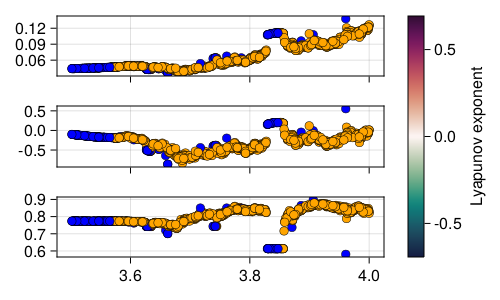

In [45]:
using CairoMakie
lmax = log(2)
exponents = results[:, 1]
# Plot quantities with color of exponents
colors = [λ < 0 ? "blue" : "orange" for λ in exponents]
colors = colors
cmap = "curl"
fig = Figure()
for i in 1:size(results, 2)-1
    ax, = scatter(fig[i,1], r_values, results[:, i+1];
        color = colors, colorrange = (-lmax, lmax),
        colormap = cmap, strokecolor = "black", strokewidth = 0.5,
    )
    i < size(results, 2)-1 && (ax.xticklabelsvisible = false)
end
# add a colorbar
cbar = fig[:, 2] = Colorbar(fig; 
    colormap = cmap, colorrange = (-lmax, lmax),
    label = "Lyapunov exponent"
)
fig

In [46]:
size(results, 2)

4

## random points from logistic

# CausalityTools.jl

This is a Julia framework for estimating quantities about the "relationship" between data, typically timeseries. There are many different "relationship" quantifiers, most of which fall under the umbrella of causal inference.

In this short tutorial, we focus on only two use cases: 
- Estimating mutual information as a better correlation quantity than traditional statistical quantities
- Estimating/inferring a small causal graph out of a group of three timeseries using transfer entropy as the quantifier.

_warning: the majority of the quantifiers in CausalityTools.jl require careful consideration for choosing their parameters. This advanced usage however falls outside the scope of this introductory tutorial_


## Mutual information as a measure of "correlation"

Typical correlation coefficients used in the literature such as Pearson/Spearman coefficients can misslead when estimating correlation between quantities that relate non-monotonically. For example, if $y = a \cdot x^2$ and $x \sim U(-1,1)$, both coefficients would yield 0 correlation between $y$ and $x$, even though they have such a clear relationship.

Let's demonstrate with an exemplary set of noisy timeseries

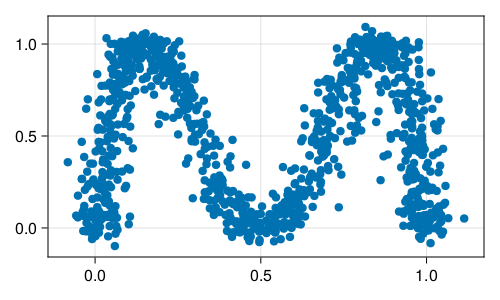

In [53]:
using DynamicalSystemsBase
lo, N = Systems.logistic(r=4), 1000
x = trajectory(lo, N-1)
y = trajectory(lo, N-1; Ttr = 2)
x .+= randn(N)/25; y .+= randn(N)/25
scatter(x, y)

In [54]:
using StatsBase: cor, corspearman
cor(x, y), corspearman(x, y)

(-0.025699085168157235, -0.016974976974976973)



An established method that estimates general correlation between $x$ and $y$ is their mutual information (MI). Its most basic definition is given by
$$
MI(x,y)  = \sum_{n}\sum_{m}
    P_{xy}(x_n,y_m)\log\left(\frac{P_{xy}(x_n, y_m)}{P_{x}(x_n)P_{y}(y_m)}\right)
$$
where here $P_x(x_n)$ means casting the $n$-th data point of $x$ into a probability, and $P_{xy}$ means the same but now for a joint distribution between $x,y$. Intuitively speaking, MI measures how much knowing one of these observables reduces uncertainty about the other. Mathematically speaking, MI is a measure of the distance between the joint distribution $P_{xy}$ of $x, y$, and the distribution they'd have if they were independent, i.e., $P_x P_y$.

In code you can calculate $MI$ with the `mutualinfo` function.

In [1]:
using CausalityTools

In [3]:
x = rand(100)
y = rand(100)
mutualinfo(ValueHistogram(21), x, y)


2.100534830249588

Just like the discussion we had in the previous blocks, there are different ways to cast the data into probabilities.

In [8]:
x = rand(100)
y = rand(100)
mutualinfo(SymbolicPermutation(m=3), x, y)

0.05442270109903145

In addition here there are different ways to calculate the mutual information from existing probabilities (the formula quoted above is one estimator only). The interface is the same, you call `mutualinfo` but now with some other "estimator", now a "mutual information estimator" rather than a "probabilities estimator". For example

In [ ]:
mutualinfo(KraskovStögbauerGrassberger2(k=5), x, y)

However, this is an advanced topic that goes beyond this course. 

Alright, let's now focus on the simplest case of estimating the MI, via the histograms and joint histogram, of $x, y$

In [9]:
mutualinfo(ValueHistogram(21), x, y)

1.9918269199330432

these MI numbers seem pretty random honestly. What we really care about is to be able to make a binary statement: are $x, y$ "correlated" according to this MI? To answer this, we do a surrogate test to reject the hypothesis "$x$ and $y$ are uncorrelated". What kind of surrogate generators satisfy this hypothesis by construction? Just shuffling the data, since this leaves $P_x$ and $P_y$ (and hence $P_xP_y$ invariant, but may ruin $P_{xy}$.

In [57]:
using TimeseriesSurrogates
surrox = surrogenerator(x, RandomShuffle())
surroy = surrogenerator(y, RandomShuffle())

Surrogate generator for input timeseries 1000-element Vector{Float64} with method:
RandomShuffle()

Just like we did in the case block of TimeseriesSurrogates.jl, we will compute the discriminatory statistic, here the mutual information, for the original data and a bunch of surrogates. For comparison, we'll also do the same for the Spearman coefficient.

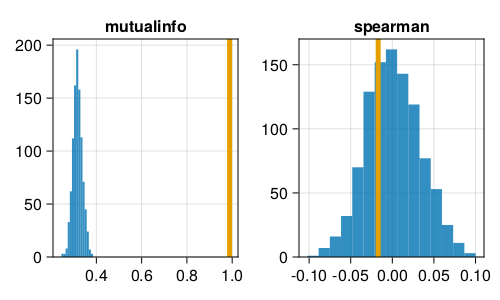

In [60]:
measures = [
    (x, y) -> mutualinfo(ValueHistogram(21), x, y),
    corspearman
]
names = ["mutualinfo", "spearman"]

N = 1000 # how many random surrogates
function surrogate_distribution(measure, N = 1000)
    # This function will use global scope, bad bad habit, but okay.
    original = measure(x, y)
    distribution = Float64[]
    for i in 1:N
        sx, sy = surrox(), surroy()
        push!(distribution, measure(sx, sy))
    end
    return original, distribution
end

fig = Figure()
for (i, measure) in enumerate(measures)
    original, distribution = surrogate_distribution(measure)
    ax, = hist(fig[1, i], distribution)
    vlines!(ax, original; color = Cycled(2), linewidth = 5)
    ylims!(ax, 0, nothing)
    ax.title = names[i]
end
fig



# Exercises